In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from graphviz import Source
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Ethen 2017-03-13 22:44:29 

CPython 3.5.2
IPython 4.2.0

numpy 1.12.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18


# Decision Tree (Classification)

Lets first create a scenario: say I want to buy a house and wish to borrow a loan from the bank. Now before giving me the loan, the bank is going to look at my history record like my credit, what has it been like in the past? How much money do I make? (and maybe some other information) and use them to determine whether loaning me money is a risky thing or not (whether I'm going to default). So how can the bank do this with decision trees?

Decision trees are formed by a collection of rules (**if-then** statements that partition the data) based on variables available from the data set. So in the example above, a very simple decision tree model could look like this:

```
if Credit = excellent then
    Outcome = Yes
else if Credit = poor then
    if Income = high then
        Outcome = Yes
    else if Income = low then
        Outcome = No
```

The algorithm works by starting at the top of the tree (the root node), then it will traverse down the branches of this decision tree and ask a series of questions. In the end it will reach the bottom of the tree (the leaf node) that contains the final outcome. For example, if somebody has a credit that's poor and his/her income is high, then the bank will say a Yes, we will give him/her the loan. 

Our task now is to learn how to generate the tree to create these decision rules for us. Thankfully, the core for learning a decision tree is a very simple recursive algorithm. A decision tree can be "learned" by splitting the dataset into subsets based on an attribute value test. This process is repeated on each derived subset in a recursive manner called recursive partitioning

1. Start at the tree's root node
2. Select the best rule/feature that splits the data into two subsets (child node) for the current node
3. Repeated step 2 on each of the derived subset until the tree can't be further splitted. As we'll later see, we can set restrictions to decide when the tree should stop growing.

There are a few additional details that we need to make more concrete. Including how to pick the rule/feature to split on and because it is a recursive algorithm, we have to figure out when to stop the recursion, or simply when to not go and split another node in the tree.

## Splitting criteria for classification trees

The first question is what is the best rule/feature to split on and how do we measure that? One way to determine this is by choosing the one that maximizes the **Information Gain (IG)** at each split.

$$IG(D_{p}, a) = I(D_{p}) - p_{left} I(D_{left}) - p_{right} I(D_{right})$$

- $IG$: Information Gain
- $a$: feature to perform the split
- $I$: Some impurity measure that we'll look at in the subsequent section
- $D_{p}$: training subset of the parent node
- $D_{left}$, $D_{right}$ :training subset of the left/right child node
- $p_{left}$, $p_{right}$: proportion of parent node samples that ended up in the left/right child node after the split. $\frac{N_{left}}{N_p}$ or $\frac{N_{right}}{N_p}$. Where:
    - $N_p$: number of samples in the parent node
    - $N_{left}$: number of samples in the left child node
    - $N_{right}$: number of samples in the right child node

## Impurity

The two most common impurity measure includes entropy, gini index.

### Entropy

Entropy is defined as:

$$I_E(t) = - \sum_{i =1}^{C} p(i \mid t) \;log_2 \,p(i \mid t)$$

for all non-empty classes, $p(i \mid t) \neq 0$, where:

- $p(i \mid t)$ is the proportion (or frequency or probability) of the samples that belong to class $i$ for a particular node $t$
- $C$ is the number of unique class labels

The entropy is therefore 0 if all samples at a node belong to the same class, and the entropy is maximal if we have an uniform class distribution. For example, in a binary class setting, the entropy is 0 if  $p(i =1 \mid t) =1$ or $p(i =0 \mid t) =1$. And if the classes are distributed uniformly with $p(i =1 \mid t) = 0.5$ and $p(i =0 \mid t) =0.5$ the entropy is 1, which we can visualize by plotting the entropy for binary class setting below.

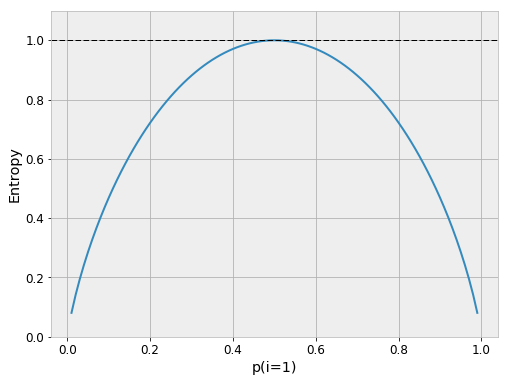

In [3]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2(( 1 - p ))

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

x = np.arange(0.0, 1.0, 0.01)
ent = [ entropy(p) if p != 0 else None for p in x]
plt.plot(x, ent)
plt.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim([ 0, 1.1 ])
plt.xlabel('p(i=1)')
plt.ylabel('Entropy')
plt.show()

### Gini Index

Gini Index is defined as:

\begin{align*}
I_G(t) &= \sum_{i =1}^{C} p(i \mid t) \big(1-p(i \mid t)\big) \nonumber \\ 
       &= \sum_{i =1}^{C} p(i \mid t) - p(i \mid t)^2 \nonumber \\ 
       &= \sum_{i =1}^{C} p(i \mid t) - \sum_{i =1}^{C} p(i \mid t)^2 \nonumber \\ 
       &= 1 - \sum_{i =1}^{C} p(i \mid t)^2
\end{align*}

Compared to Entropy, the maximum value of the Gini index is 0.5, which occurs when the classes are perfectly balanced in a node. On the other hand, the minimum value of the Gini index is 0 and occurs when there is only one class represented in a node (A node with a lower Gini index is said to be more "pure").

This time we plot Entropy and Gini index together to compare them against each other.

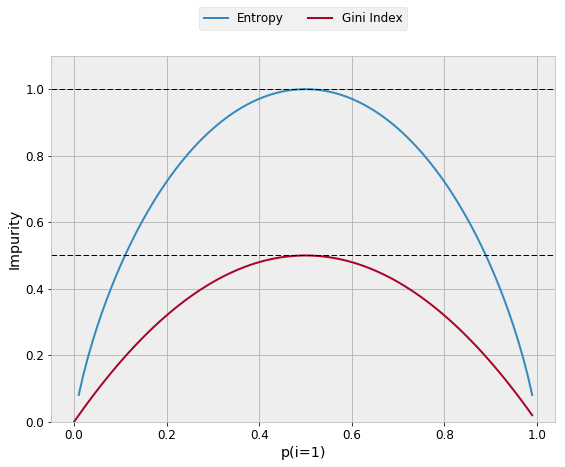

In [4]:
def gini(p):
    return p * (1 - p) + (1 - p) * ( 1 - (1 - p) )

gi = gini(x)

# plot
for i, lab in zip( [ ent, gini(x) ], ['Entropy', 'Gini Index'] ):
    plt.plot(x, i, label = lab)

plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15),
           ncol = 3, fancybox = True, shadow = False)
plt.axhline(y = 0.5, linewidth = 1, color = 'k', linestyle = '--')
plt.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim([ 0, 1.1 ])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity')
plt.tight_layout()
plt.show()

As we can see from the plot, there is not much differences (as in they both increase and decrease at similar range). In practice, Gini Index and Entropy typically yield very similar results and it is often not worth spending much time on evaluating decision tree models using different impurity criteria. As for which one to use, maybe consider Gini Index, because this way, we don’t need to compute the log, which can make it a bit computationly faster.

Decision trees can also be used on regression task. It's just instead of using gini index or entropy as the impurity function, we use criteria such as MSE (mean square error):

$$I_{MSE}(t) = \frac{1}{N_t} \sum_i^{N_t}(y_i - \bar{y})^2$$

Where $\bar{y}$ is the averages of the response at node $t$, and $N_t$ is the number of observations that reached node $t$. This is simply saying, we compute the differences between all $N_t$ observation's reponse to the average response, square it and take the average.

## Concrete Example

Here we'll calculate the Entropy score by hand to hopefully make things a bit more concrete. Using the bank loan example again, suppose at a particular node, there are 80 observations, of whom 40 were classified as Yes (the bank will issue the loan) and 40 were classified as No.

We can first calculate the Entropy before making a split:

$$I_E(D_{p}) = - \left( \frac{40}{80} log_2(\frac{40}{80}) + \frac{40}{80} log_2(\frac{40}{80}) \right) = 1$$

Suppose we try splitting on Income, as the child nodes turn out to be.

- Left (Income = high): 30 Yes and 10 No
- Right (Income = low): 10 Yes and 30 No

$$I_E(D_{left}) = - \left( \frac{30}{40} log_2(\frac{30}{40}) + \frac{10}{40} log_2(\frac{10}{40}) \right) = 0.81$$
$$I_E(D_{right}) = - \left( \frac{10}{40} log_2(\frac{10}{40}) + \frac{30}{40} log_2(\frac{30}{40}) \right) = 0.81$$
$$IG(D_{p}, Income) = 1 - \frac{40}{80} (0.81) - \frac{40}{80} (0.81) = 0.19$$

Next we repeat the same process and evaluate the split based on splitting by Credit.

- Left (Credit = excellent): 20 Yes and 0 No
- Right (Credit = poot): 20 Yes and 40 No

$$I_E(D_{left}) = - \left( \frac{20}{20} log_2(\frac{20}{20}) + \frac{0}{20} log_2(\frac{0}{20}) \right) = 0$$
$$I_E(D_{right}) = - \left( \frac{20}{60} log_2(\frac{20}{60}) + \frac{40}{60} log_2(\frac{40}{60}) \right) = 0.92$$
$$IG(D_{p}, Credit) = 1 - \frac{20}{80} (0) - \frac{60}{80} (0.92) = 0.31$$

In this case, it will choose Credit as the feature to split upon.

If we were to have more features, the decision tree algorithm will simply try every possible split, and will choose the split that maximizes the information gain. If the feature is a continuous variable, then we can simply get the unique values of that feature in a sorted order, then try all possible split values (threshold) by using cutoff point (average) between every two values (e.g. a unique value of 1, 2, 3 will result in trying the split on the value 1.5 and 2.5). Or to speed up computations, we can bin the unqiue values into buckets, and split on the buckets.

## When To Stop Recursing

The other question that we need to address is when to stop the tree from growing. There are some early stopping criteria that is commonly used to prevent the tree from overfitting.

- **Maximum depth** The length of the longest path from a root node to a leaf node will not exceed this value. This is the most commonly tuned hyperparameter for tree-based method
- **Minimum sample split:** The minimum number of samples required to split a node should be greater than this number
- **Minimum information gain** The minimum information gain required for splitting on the best feature

And that's pretty much it for classification trees! For a more visual appealing explanation, the following link this a website that uses interactive visualization to demonstrate how decision trees work. [A Visual Introduction to Machine Learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

## Implementation

With all of that in mind, the following section implements a toy classification tree algorithm.

In [5]:
class Tree:
    """
    Classification tree using information gain with entropy as impurity
        
    Parameters
    ----------
    max_features : int or None, default None
        The number of features to consider when looking for the best split,
        None uses all features
    
    min_samples_split : int, default 10
        The minimum number of samples required to split an internal node
    
    max_depth : int, default 3
        Maximum depth of the tree
    
    minimum_gain : float, default 1e-7
        Minimum information gain required for splitting
    """
    def __init__(self, max_depth = 3, max_features = None, 
                 minimum_gain = 1e-7, min_samples_split = 10):
    
        self.max_depth = max_depth
        self.max_features = max_features
        self.minimum_gain = minimum_gain
        self.min_samples_split = min_samples_split
        
    def fit(self, X, y):
        """pass in the 2d-array dataset and the response column"""
        self.n_class = np.unique(y).shape[0]
        
        # in the case you're wondering why we have this implementation of
        # choosing the number of features to consider when looking
        # for the best split, it will become much clearer when we
        # start discussing Random Forest algorithm
        if self.max_features is None or self.max_features > X.shape[1]:
            self.max_features = X.shape[1]
        
        self.tree = _create_decision_tree(X, y, self.max_depth, 
                                          self.minimum_gain, self.max_features,
                                          self.min_samples_split, self.n_class)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        pred = np.argmax(proba, axis = 1)
        return pred

    def predict_proba(self, X):
        proba = np.empty(( X.shape[0], self.n_class ))
        for i in range(X.shape[0]):
            proba[i] = self._predict_row( X[i, :], self.tree )
        
        return proba
    
    def _predict_row(self, row, tree):
        """Predict single row"""
        if tree['is_leaf']:
            return tree['prob']
        else:
            if row[ tree['split_col'] ] <= tree['threshold']:
                return self._predict_row( row, tree['left'] )
            else:
                return self._predict_row( row, tree['right'] )

In [6]:
def _create_decision_tree(X, y, max_depth, 
                          minimum_gain, max_features, 
                          min_samples_split, n_class):
    """recursively grow the decision tree until it reaches the stopping criteria"""
    try:
        assert max_depth > 0
        assert X.shape[0] > min_samples_split    
        column, value, gain = _find_best_split(X, y, max_features)
        assert gain > minimum_gain
        
        # split the dataset and grow left and right child
        left_X, right_X, left_y, right_y = _split(X, y, column, value)
        left_child  = _create_decision_tree(left_X, left_y, max_depth - 1, 
                                            minimum_gain, max_features,
                                            min_samples_split, n_class)
        right_child = _create_decision_tree(right_X, right_y, max_depth - 1,
                                            minimum_gain, max_features, 
                                            min_samples_split, n_class)
    except AssertionError:
        # if criteria reached, compute the classification
        # probability and return it as a leaf node
        
        # note that some leaf node may only contain partial classes,
        # thus specify the minlength to class that don't appear will
        # still get assign a probability of 0
        counts = np.bincount(y, minlength = n_class)
        prob = counts / y.shape[0]
        leaf = { 
            'is_leaf' : True,  
            'prob': prob
        }
        return leaf
    
    node = { 
        'is_leaf' : False, 
        'left' : left_child,
        'right' : right_child,
        'split_col': column,
        'threshold': value
    }    
    return node
    
def _find_best_split(X, y, max_features):
    """Greedy algorithm to find the best feature and value for a split"""
    subset = np.random.choice( X.shape[1], max_features, replace = False )
    max_col, max_val, max_gain = None, None, None
    parent_entropy = _compute_entropy(y)
        
    for column in subset:
        split_values = _find_splits(X, column)           
        for value in split_values:
            splits = _split(X, y, column, value, return_X = False)
            gain = parent_entropy - _compute_splits_entropy(y, splits)

            if max_gain is None or gain > max_gain:
                max_col, max_val, max_gain = column, value, gain
                
    return max_col, max_val, max_gain

def _compute_entropy(split):
    """entropy score using a fix log base 2"""
    _, counts = np.unique(split, return_counts = True)
    p = counts / split.shape[0]
    entropy = -np.sum( p * np.log2(p) )
    return entropy

def _find_splits(X, column):
    """
    find all possible split values (threshold),
    by getting unique values in a sorted order
    and finding cutoff point (average) between every two values
    """
    X_unique = np.unique(X[:, column])
    split_values = np.empty(X_unique.shape[0] - 1)
    for i in range( 1, X_unique.shape[0] ):
        average = ( X_unique[i - 1] + X_unique[i] ) / 2
        split_values[i - 1] = average
        
    return split_values

def _compute_splits_entropy(y, splits):
    """compute the entropy for the splits (the two child nodes)"""
    splits_entropy = 0
    for split in splits:
        splits_entropy += ( split.shape[0] / y.shape[0] ) * _compute_entropy(split)

    return splits_entropy
    
def _split(X, y, column, value, return_X = True):
    """split the response column using the cutoff threshold"""
    left_mask = X[:, column] <= value
    right_mask = X[:, column] > value
    left_y, right_y = y[left_mask], y[right_mask]
    
    if not return_X:
        return left_y, right_y
    else:
        left_X, right_X = X[left_mask], X[right_mask]
        return left_X, right_X, left_y, right_y

We will load the [Iris dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), and use it as a sample dataset to test our algorithm. This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica). It is stored as a 150x4 numpy.ndarray, where the rows are the samples and the columns being Sepal Length, Sepal Width, Petal Length and Petal Width.

In [7]:
# load a sample dataset
iris = load_iris()
X = iris.data
y = iris.target

# train model and print the accuracy score
tree = Tree()
tree.fit(X, y)
y_pred = tree.predict(X)
print( 'classification distribution: ', np.bincount(y_pred) )
print( 'accuracy score: ', accuracy_score(y, y_pred) )

classification distribution:  [50 48 52]
accuracy score:  0.973333333333


In [8]:
# use library to confirm results are comparable
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10, max_depth = 3)
clf.fit(X, y)
y_pred = clf.predict(X)
print( 'classification distribution: ', np.bincount(y_pred) )
print( 'accuracy score: ', accuracy_score(y, y_pred) )

classification distribution:  [50 48 52]
accuracy score:  0.973333333333


**Advantages of decision trees:**


- Features don't require scaling or normalization
- Great at dealing with data that have lots of categorical features
- Can be displayed graphically, thus making it highly interpretable (in the next code chunk)
- It is non-parametric, thus it will outperform linear models if relationship between features and response is highly non-linear

For visualizing the decision tree, you might need to have graphviz installed. For the mac user, try following the instructions in this [link](http://macappstore.org/graphviz-2/).

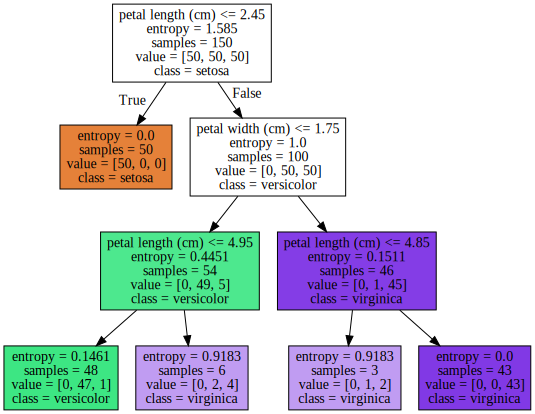

In [9]:
# visualize the decision tree

# export it as .dot file, other common parameters include
# `rounded` (boolean to round the score on each node)
export_graphviz(clf, feature_names = iris.feature_names, filled = True,
                class_names = iris.target_names, out_file = 'tree.dot')

# read it in and visualize it, or if we wish to
# convert the .dot file into other formats, we can do:
# import os
# os.system('dot -Tpng tree.dot -o tree.jpeg')
with open('tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)

# Reference

- [scikit-learn Documentation: Decision Trees](http://scikit-learn.org/stable/modules/tree.html)
- [Blog: The advantages of the different impurity metrics](http://sebastianraschka.com/faq/docs/decision-tree-binary.html)
- [Notebook: Cheatsheet for Decision Tree Classification](http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/decision_trees/decision-tree-cheatsheet.ipynb)
- [Github: Minimal and clean examples of machine learning algorithms](https://github.com/rushter/MLAlgorithms/blob/master/mla/ensemble/tree.py)